In [1]:
import arch
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import statsmodels.api as sm
import warnings
import yfinance as yf
from datetime import date, datetime, timedelta
from operator import itemgetter
from typing import List, Tuple

from etl.load_volatility import get_data_with_vix
from indicators.transform import build_features
from indicators.temporal_features import difference_features


sns.set_style("darkgrid")

In [7]:
def train_and_predict(features, target, num_test, regularise, prediction_colname):
    # Compute rolling predictions at time t, using only data up to t-1.
    predictions = []
    for i in range(num_test):
        test_index = -(num_test-i)
        
        # Train - IS Data.
        X_train = features.iloc[:test_index]
        y_train = target.iloc[:test_index]

        # Linear Regression vs. ElasticNet (GLMNet).
        model = sm.OLS(endog=y_train, exog=X_train)
        model = model.fit_regularized() if regularise else model.fit()

        # Test - OOS Data: note double [[]] to preserve batch_dim==1.
        X_test = features.iloc[[test_index]]
        y_test = target.iloc[[test_index]]

        prediction = model.predict(X_test)
        predictions.append(prediction)

    # Align predictions.
    pred_series = pd.concat(predictions, axis=0)
    pred_series.name = prediction_colname
    pred_df = pred_series.to_frame()
    
    return pred_df, model



def plot_results(df):
    fig = plt.figure()
    fig.set_size_inches(16, 4)

    warmup = 20
    plt.plot(df["price_target"].iloc[warmup:], label="target")
    plt.plot(df["pred"].iloc[warmup:], label="pred")
    plt.plot(df["pred_reg"].iloc[warmup:], label="pred_reg", alpha=0.5)
    plt.title("Prediction vs. Target")
    plt.legend()
    plt.show()

In [8]:
def main(ticker, vix, start_date, end_date, interval, do_difference):

    df = get_data_with_vix(ticker, vix=vix, start_date=start_date, end_date=end_date, interval=interval)
    
    # Perform any differencing of raw input features first s.t. downstream features are differenced by construction.
    if do_difference:
        df = df.pipe(difference_features, colnames=["price", "volume", "vix"])
    
    features, target = build_features(df, features_cols=["price", "volume", "vix"], add_lag_features={"price": [1, 2, 3, 7]}, add_yearly_features=True)

    # Need at least 1 data point to fit model.
    num_test = len(df) - 1
    pred_df, model = train_and_predict(features, target, num_test, regularise=False, prediction_colname="pred")
    pred_reg_df, model_reg = train_and_predict(features, target, num_test, regularise=True, prediction_colname="pred_reg")

    # Join predictions with input data on date index.
    output_df = df.join(pred_df)
    output_df = output_df.join(pred_reg_df)
    
    print("Final Model")
    model_df = pd.DataFrame.from_dict({"params": model.params, "pvalues": model.pvalues})
    reject_h0 = model_df.query("pvalues <= 0.05")
    fail_reject_h0 = model_df.query("pvalues > 0.05")
    print(model_df)
    print("-"*20)
    print(f"Reject H0:\n {reject_h0}")
    print("-"*20)
    print(f"Fail to reject H0:\n {fail_reject_h0}")

    plot_results(output_df)
    
    return model, output_df

# Compare results with and without differencing the raw features

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Final Model
                       params        pvalues
const            7.402619e-02   8.342984e-01
price            7.224408e-01  6.221204e-141
volume          -2.236894e-07   4.374053e-01
vix              7.675023e-03   8.084059e-03
price-1          1.616908e-01   4.857649e-07
price-2          4.853221e-02   1.256107e-01
price-3          4.442653e-02   1.102441e-01
price-7          1.889093e-02   2.617612e-01
cos_day_of_year  3.874534e-02   6.629874e-01
sin_day_of_year  1.779492e-02   8.453765e-01
--------------------
Reject H0:
            params        pvalues
price    0.722441  6.221204e-141
vix      0.007675   8.084059e-03
price-1  0.161691   4.857649e-07
--------------------
Fail to reject H0:
                        params   pvalues
const            7.402619e-02  0.834298
volume          -2.236894e-07  0.437405
price-2          4.853221e-02

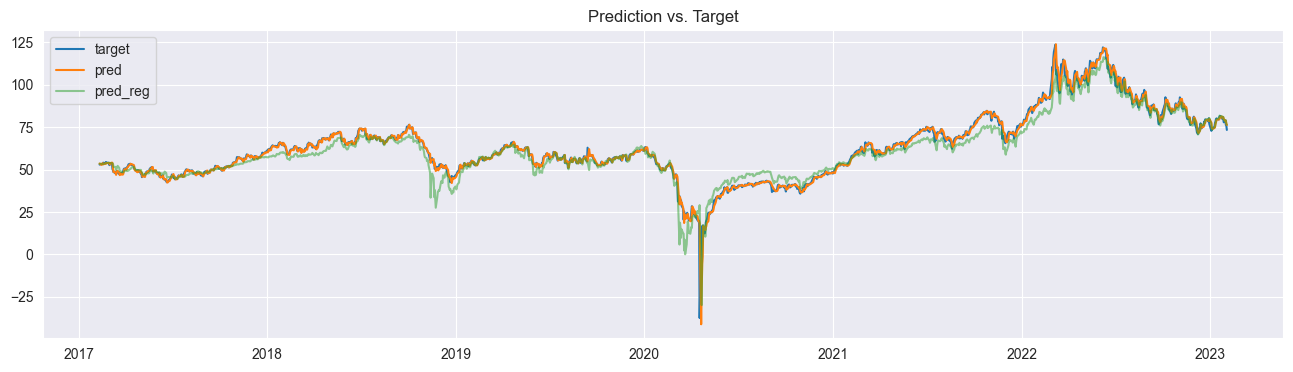

In [9]:
ticker = "CL=F"
vix = "^OVX"
interval = "1d"
end_date = date.today()
start_date = datetime.strptime("2017-01-01", "%Y-%m-%d")


model, df = main(ticker=ticker, vix=vix, start_date=start_date, end_date=end_date, interval=interval, do_difference=False)

In [ ]:
model_dff, df_diff = main(ticker=ticker, vix=vix, start_date=start_date, end_date=end_date, interval=interval, do_difference=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Other Plots

In [ ]:
end_date = date.today()
start_date = num_data_to_start_date(num_data=10000, interval=interval, end_date=end_date)    

df = get_data_with_vix(ticker, vix="^VIX", start_date=start_date, end_date=end_date, interval=interval)

fig = plt.figure()
fig.set_size_inches(16, 4)

plt.plot(df["vix"], label="VIX")
plt.legend()
plt.show()